## **Grouping Feedback Model**

**Step 1. Import Library**

In [1]:
#importing the library
import csv
import random
import numpy as np
import pandas as pd
import pickle
import string, re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Step 2. Reading the raw data**

In [2]:
#panggil dataset yang telah disimpan di Google Drive pribadi
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
SENTIMENT_CSV = "/content/drive/MyDrive/Pribadi/data_feedbacks.csv"

with open(SENTIMENT_CSV, 'r') as csvfile:
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

First data point looks like this:

label,ulasan

Second data point looks like this:

1,"Secara keseluruhan saya menyukai aplikasi ini, tetapi masih ada beberapa masalah. Beberapa di antaranya adalah ketika memasang spoiler ke media, sebagian besar masih tidak berfungsi. Yang lainnya (dan jujur, yang paling menjengkelkan) adalah ketika saya menggunakan obrolan suara,   sering secara otomatis menutup sendiri setelah beberapa waktu saat saya sedang bermain ... Full Review"



**Step 3. Pre-processing**

In [4]:
#remove_stopwords
def remove_stopwords(ulasan):
    # List of stopwords
    stopwords = ["yang", "untuk", "pada", "ke", "para", "namun", "menurut", "antara", "dia", "dua", "ia", "seperti", 
              "jika", "sehingga", "kembali", "dan", "karena", "kepada", "oleh", "saat", "harus", "sementara", 
              "setelah", "belum", "kami", "sekitar", "bagi", "serta", "di", "dari", "telah", "sebagai", "masih", 
              "hal", "ketika", "adalah", "itu", "dalam", "bisa", "bahwa", "atau", "hanya", "kita", "dengan", "akan", 
              "juga", "ada", "mereka", "sudah", "saya", "terhadap", "secara", "agar", "lain", "anda", "begitu", "mengapa", 
              "kenapa", "yaitu", "yakni", "daripada", "itulah", "lagi", "maka", "tentang", "demi", "dimana", "kemana",
              "pula", "sambil", "sebelum", "sesudah", "supaya", "guna", "kah", "pun", "sampai", "sedangkan", "selagi",
              "sementara", "tetapi", "apakah", "kecuali", "sebab", "selain", "seolah", "seterusnya", "tanpa", "agak",
              "boleh", "dapat", "dsb", "dst", "dll", "dahulu", "dulunya", "anu", "demikian", "tapi", "ingin", "juga",
              "nggak", "mari", "nanti", "melainkan", "oh", "ok", "seharusnya", "sebetulnya", "setiap", "setidaknya",
              "sesuatu", "pasti", "saja", "toh", "walau", "tolong", "tentu", "amat", "apalagi", "bagaimanapun",
              "dengan", "ia", "bahwa", "oleh"]

    # Ulasan converted to lowercase-only
    ulasan = str(ulasan).lower()
    
    ### START CODE HERE
    
    # Use this to read file content as a stream:
    words = ulasan.split()
    ulasan = []
    for r in words:
        if not r in stopwords:
            ulasan.append(r)
            
    ulasan=" ".join(ulasan)
    ### END CODE HERE
    return ulasan

In [5]:
def parse_data_from_file(filename):
    ulasan = []
    label = []
    with open(filename, 'r') as csvfile:
        ### START CODE HERE
        skip = True
        if skip:
            skip = False
            reader = csv.reader(csvfile, delimiter=',')
            next(reader)

            for row in reader:
                row[0] = remove_stopwords(row[0])
                row[1] = remove_stopwords(row[1])
                label.append(row[0])
                ulasan.append(row[1])
            
        ### END CODE HERE
    return ulasan, label

In [6]:
# Test function
ulasan, label = parse_data_from_file(SENTIMENT_CSV)

print(f"dataset contains {len(ulasan)} examples\n")

print(f"Text of second example should look like this:\n{ulasan[1]}\n")
print(f"Text of fourth example should look like this:\n{ulasan[3]}")

print(f"\nLabels of last 5 examples should look like this:\n{label[-5:]}")

dataset contains 200 examples

Text of second example should look like this:
sebenarnya aplikasi sangat bagus layak. memberi peringkat 4/5 tidak mengirim catatan suara (alias vn). terkadang setengah bangun keyboard lag, tidak mengetik, berarti tidak membalas sms orang. catatan suara sebenarnya sangat berguna sebagian orang! tidak memiliki... ulasan lengkap

Text of fourth example should look like this:
beri 4 bintang versi pc memiliki fitur berpindah akun instan-- versi cp tidak. sangat nyaman digunakan berpindah akun semudah versi pc. itu, mb mengirim foto video terlalu terbatas. bahkan itu, aplikasi bagus. hanya... ulasan lengkap

Labels of last 5 examples should look like this:
['1', '0', '0', '0', '0']


In [7]:
def preprocess(ulasan):
    ulasan = ulasan.lower() 
    ulasan = ulasan.strip()  
    ulasan = re.compile('<.*?>').sub('', ulasan) 
    ulasan = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', ulasan)  
    ulasan = re.sub('\s+', ' ', ulasan)  
    ulasan = re.sub(r'\[*\]',' ',ulasan) 
    ulasan = re.sub(r'[^\w\s]', '', str(ulasan).lower().strip())
    ulasan = re.sub(r'\d',' ',ulasan) 
    ulasan = re.sub(r'\s+',' ',ulasan) 
    return ulasan

**Step 4. Final Pre-Processing**

In [8]:
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(ulasan):
    word_pos_tags = nltk.pos_tag(word_tokenize(ulasan)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [9]:
def finalpreprocess(ulasan):
    return lemmatizer(remove_stopwords(preprocess(ulasan)))

In [10]:
df = pd.read_csv('/content/drive/MyDrive/Pribadi/data_feedbacks.csv')

In [11]:
df['clean_text'] = df['ulasan'].apply(lambda x: finalpreprocess(x))
df.head()

,label,ulasan,clean_text
0,1,"Secara keseluruhan saya menyukai aplikasi ini,...",keseluruhan menyukai aplikasi ini beberapa mas...
1,1,sebenarnya adalah aplikasi yang sangat bagus...,sebenarnya aplikasi sangat bagus layak memberi...
2,1,Jujur luar biasa. Saya menganggap ini platform...,jujur luar biasa menganggap ini platform mediu...
3,1,Saya beri 4 bintang karena versi PC memiliki f...,beri bintang versi pc memiliki fitur berpindah...
4,0,1. Autoscroll ke bawah tidak dapat dinonaktifk...,autoscroll bawah tidak dinonaktifkan sangat me...


**Step 5. Defining some useful global variables**

In [12]:
EMBEDDING_DIM = 100
MAXLEN = 16
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 160000
TRAINING_SPLIT = 0.9

**Step 6. Training - Validation Split**

In [13]:
def train_val_split(ulasan, label, training_split):

    train_size = int(len(ulasan)*training_split)

    # Split the ulasan and label into train/validation splits
    train_ulasan = ulasan[:train_size]
    train_label = label[:train_size]

    validation_ulasan = ulasan[train_size:]
    validation_label = label[train_size:]
    
    return train_ulasan, validation_ulasan, train_label, validation_label

In [14]:
# Test function
train_ulasan, val_ulasan, train_label, val_label = train_val_split(ulasan, label, TRAINING_SPLIT)

print(f"There are {len(train_ulasan)} ulasan for training.\n")
print(f"There are {len(train_label)} label for training.\n")
print(f"There are {len(val_ulasan)} ulasan for validation.\n")
print(f"There are {len(val_label)} label for validation.")

There are 180 ulasan for training.

There are 180 label for training.

There are 20 ulasan for validation.

There are 20 label for validation.


**Step 7.Tokenization - Sequences, truncating and padding**

In [15]:
def fit_tokenizer(train_ulasan, oov_token):

    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words = len(train_ulasan), oov_token="<OOV>")
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_ulasan)
    
    return tokenizer

In [16]:
# Test function
tokenizer = fit_tokenizer(train_ulasan, OOV_TOKEN)

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary contains {VOCAB_SIZE} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")
print(f"\nindex of word 'i' should be {word_index['i']}")

Vocabulary contains 1356 words

<OOV> token included in vocabulary

index of word 'i' should be 1071


In [17]:
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):

    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding, truncating and maxlen
    pad_trunc_sequences = pad_sequences(sequences, padding='post', truncating='post', maxlen=maxlen)

    return pad_trunc_sequences

In [18]:
# Test function
train_pad_trunc_seq = seq_pad_and_trunc(train_ulasan, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_and_trunc(val_ulasan, tokenizer, PADDING, TRUNCATING, MAXLEN)

print(f"Padded and truncated training sequences have shape: {train_pad_trunc_seq.shape}\n")
print(f"Padded and truncated validation sequences have shape: {val_pad_trunc_seq.shape}")

Padded and truncated training sequences have shape: (180, 16)

Padded and truncated validation sequences have shape: (20, 16)


In [19]:
train_label = np.array(train_label, dtype='f4')
val_label = np.array(val_label, dtype='f4')

**Step 8. Using pre-defined Embeddings**

In [20]:
# Define path to file containing the embeddings
GLOVE_FILE = '/content/drive/MyDrive/Pribadi/glove.6B.100d.txt'

# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS = {}

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

In [21]:
test_word = 'dog'

test_vector = GLOVE_EMBEDDINGS[test_word]

print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")

Vector representation of word dog looks like this:

[ 0.30817    0.30938    0.52803   -0.92543   -0.73671    0.63475
  0.44197    0.10262   -0.09142   -0.56607   -0.5327     0.2013
  0.7704    -0.13983    0.13727    1.1128     0.89301   -0.17869
 -0.0019722  0.57289    0.59479    0.50428   -0.28991   -1.3491
  0.42756    1.2748    -1.1613    -0.41084    0.042804   0.54866
  0.18897    0.3759     0.58035    0.66975    0.81156    0.93864
 -0.51005   -0.070079   0.82819   -0.35346    0.21086   -0.24412
 -0.16554   -0.78358   -0.48482    0.38968   -0.86356   -0.016391
  0.31984   -0.49246   -0.069363   0.018869  -0.098286   1.3126
 -0.12116   -1.2399    -0.091429   0.35294    0.64645    0.089642
  0.70294    1.1244     0.38639    0.52084    0.98787    0.79952
 -0.34625    0.14095    0.80167    0.20987   -0.86007   -0.15308
  0.074523   0.40816    0.019208   0.51587   -0.34428   -0.24525
 -0.77984    0.27425    0.22418    0.20164    0.017431  -0.014697
 -1.0235    -0.39695   -0.0056188  0.3

In [22]:
print(f"Each word vector has shape: {test_vector.shape}")

Each word vector has shape: (100,)


**Step 9. Represent the words in your vocabulary using the embeddings**

In [23]:
# Initialize an empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for 
# each word exists within GloVe's representations, save it in the EMBEDDINGS_MATRIX array
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

**Step 10. Define a model that does not overfit**

In [24]:
import tensorflow as tf

In [25]:
def create_model(vocab_size, embedding_dim, maxlen, embedding_matrix):
    
    model = tf.keras.Sequential([ 
        # This is how you need to set the Embedding layer when using pre-trained embeddings
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=False), 
        tf.keras.layers.Conv1D(64, 5, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.MaxPooling1D(pool_size=4),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy',
                  optimizer= tf.keras.optimizers.Adam(lr=0.001),
                  metrics=['accuracy']) 

    return model

In [26]:
# Create your untrained model
model = create_model(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)

# Train the model and save the training history
history = model.fit(train_pad_trunc_seq, train_label, epochs=20, validation_data=(val_pad_trunc_seq, val_label))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


6/6 [==============================] - 3s 125ms/step - loss: 0.6919 - accuracy: 0.5500 - val_loss: 0.7367 - val_accuracy: 0.3000
Epoch 2/20
6/6 [==============================] - 0s 12ms/step - loss: 0.6671 - accuracy: 0.5389 - val_loss: 0.7267 - val_accuracy: 0.2000
Epoch 3/20
6/6 [==============================] - 0s 13ms/step - loss: 0.6579 - accuracy: 0.6056 - val_loss: 0.6633 - val_accuracy: 0.6500
Epoch 4/20
6/6 [==============================] - 0s 13ms/step - loss: 0.6280 - accuracy: 0.7000 - val_loss: 0.6569 - val_accuracy: 0.6500
Epoch 5/20
6/6 [==============================] - 0s 13ms/step - loss: 0.5936 - accuracy: 0.6944 - val_loss: 0.6444 - val_accuracy: 0.6000
Epoch 6/20
6/6 [==============================] - 0s 12ms/step - loss: 0.5537 - accuracy: 0.7833 - val_loss: 0.5667 - val_accuracy: 0.8000
Epoch 7/20
6/6 [==============================] - 0s 14ms/step - loss: 0.5080 - accuracy: 0.8056 - val_loss: 0.5332 - val_accuracy: 0.8000
Epoch 8/20
6/6 [=====================

In [27]:
import matplotlib.pyplot as plt

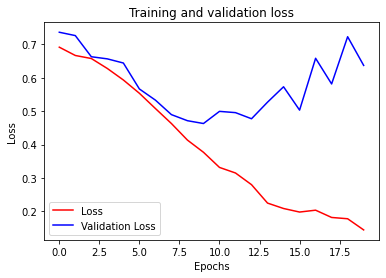

In [28]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = [*range(20)]

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

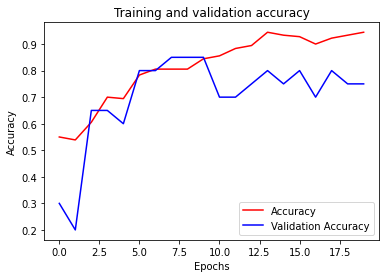

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

A more rigorous way of setting the passing threshold of this assignment is to use the slope of your `val_loss` curve.

**To pass this model the slope of your `val_loss` curve should be 0.0005 at maximum.**

In [30]:
from scipy.stats import linregress

In [31]:
# Test the slope of your val_loss curve
slope, *_ = linregress(epochs, val_loss)
print(f"The slope of your validation loss curve is {slope:.5f}")

The slope of your validation loss curve is -0.00349


In [32]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

**Step 11. Saved Model**

In [33]:
export_dir = '/content/drive/MyDrive/Pribadi/saved/'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Pribadi/saved/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Pribadi/saved/assets


**Step 12. Predict Text**

In [34]:
#call the new dataset
df_test = pd.read_csv("/content/drive/MyDrive/Pribadi/dataset/data_feedbacks_test.csv")

In [35]:
#Pre-processing the new dataset
df_test['clean_text'] = df_test['ulasan'].apply(lambda x: finalpreprocess(x)) #preprocess the data
X_test=df_test['clean_text'][2] 
print(X_test)
sequence = tokenizer.texts_to_sequences([X_test])
pad_sequence = pad_sequences(sequence, padding=PADDING, truncating=TRUNCATING, maxlen=MAXLEN)
y_predict = model.predict(pad_sequence)[0][0]       
if y_predict > 0.6:
  print("Positive")
else:
  print("Negative")

autoscroll bawah tidak dinonaktifkan sangat mengganggu membaca riwayat obrolan mencari memilih hasil tidak daftar semua hasil pencarian mengklik tombol pencarian scoll diatur ulang ini bukan ilmu roket sebuah ulasan lengkap
Negative
